# Example using GEFS Reforecast Data from AWS
#### Dr. Victor Gensini (Summer 2020)
#### Department of Geographic and Atmospheric Sciences
<br>
<img src="https://www.niu.edu/communication-standards/_images/signaturelogo.png" style="height:60px;float:left">

Import Libraries

In [1]:
import xarray as xr
import numpy as np
import cartopy
import glob
import matplotlib.pyplot as plt
%matplotlib inline

Use xarray to open all cape_sfc and hlcy_hght grib2 files for a specific cycle. Here, I have downloaded the control and four purtabation members. You could also use `engine='cfgrib'`. 

In [2]:
glob.glob('*.grib2')

['hlcy_hgt_2019051700_p01.grib2',
 'hlcy_hgt_2019051700_p02.grib2',
 'hlcy_hgt_2019051700_p03.grib2',
 'hlcy_hgt_2019051700_p04.grib2',
 'hlcy_hgt_2019051700_c00.grib2',
 'cape_sfc_2019051700_c00.grib2',
 'cape_sfc_2019051700_p01.grib2',
 'cape_sfc_2019051700_p02.grib2',
 'cape_sfc_2019051700_p03.grib2',
 'cape_sfc_2019051700_p04.grib2']

In [3]:
cape_ds = xr.open_mfdataset("cape_sfc_*", engine='pynio', concat_dim="ensemble", combine='nested')
hlcy_ds = xr.open_mfdataset("hlcy_hgt_*", engine='pynio', concat_dim="ensemble", combine='nested')

Get a sense of the data structure...

In [4]:
print(cape_ds)
print(hlcy_ds)

<xarray.Dataset>
Dimensions:          (ensemble: 5, forecast_time0: 80, lat_0: 721, lon_0: 1440)
Coordinates:
  * lon_0            (lon_0) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * forecast_time0   (forecast_time0) timedelta64[ns] 03:00:00 ... 10 days 00:00:00
  * lat_0            (lat_0) float32 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Dimensions without coordinates: ensemble
Data variables:
    CAPE_P1_L1_GLL0  (ensemble, forecast_time0, lat_0, lon_0) float32 dask.array<chunksize=(1, 80, 721, 1440), meta=np.ndarray>
<xarray.Dataset>
Dimensions:             (ensemble: 5, forecast_time0: 80, lat_0: 721, lon_0: 1440)
Coordinates:
  * lon_0               (lon_0) float32 0.0 0.25 0.5 ... 359.25 359.5 359.75
  * forecast_time0      (forecast_time0) timedelta64[ns] 03:00:00 ... 10 days 00:00:00
  * lat_0               (lat_0) float32 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Dimensions without coordinates: ensemble
Data variables:
    HLCY_P1_2L103_GLL0  (ensemble, forecast_time0, la

Calculate the Energy Helicity Index (EHI) across the cycle. 

In [5]:
ehi_ds = cape_ds.CAPE_P1_L1_GLL0 * hlcy_ds.HLCY_P1_2L103_GLL0 / 160000.
ehi_ds

<xarray.DataArray (ensemble: 5, forecast_time0: 80, lat_0: 721, lon_0: 1440)>
dask.array<truediv, shape=(5, 80, 721, 1440), dtype=float32, chunksize=(1, 80, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon_0           (lon_0) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * forecast_time0  (forecast_time0) timedelta64[ns] 03:00:00 ... 10 days 00:00:00
  * lat_0           (lat_0) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Dimensions without coordinates: ensemble

Convert the longitude values to degrees east and west, then sort by the longitude values so they are monotonically increasing. 

In [6]:
ehi_ds = ehi_ds.assign_coords(lon_1=(((ehi_ds.lon_0 + 180) % 360) - 180)).sortby(ehi_ds.lon_0)
ehi_ds

<xarray.DataArray (ensemble: 5, forecast_time0: 80, lat_0: 721, lon_0: 1440)>
dask.array<getitem, shape=(5, 80, 721, 1440), dtype=float32, chunksize=(1, 80, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon_0           (lon_0) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * forecast_time0  (forecast_time0) timedelta64[ns] 03:00:00 ... 10 days 00:00:00
  * lat_0           (lat_0) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    lon_1           (lon_0) float32 0.0 0.25 0.5 0.75 ... -1.0 -0.75 -0.5 -0.25
Dimensions without coordinates: ensemble

EHI time series at Oklahoma City, OK

In [7]:
okc_ehi_ds = ehi_ds.sel(lat_0=35.4,lon_0=-97., method='nearest')
okc_ehi_ds

<xarray.DataArray (ensemble: 5, forecast_time0: 80)>
dask.array<getitem, shape=(5, 80), dtype=float32, chunksize=(1, 80), chunktype=numpy.ndarray>
Coordinates:
    lon_0           float32 0.0
  * forecast_time0  (forecast_time0) timedelta64[ns] 03:00:00 ... 10 days 00:00:00
    lat_0           float32 35.5
    lon_1           float32 0.0
Dimensions without coordinates: ensemble

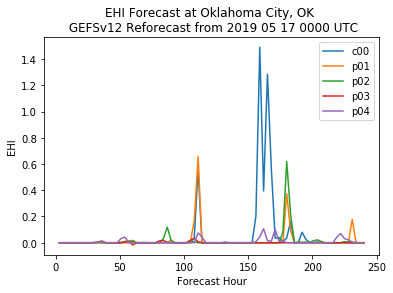

In [8]:
plt.plot(okc_ehi_ds.forecast_time0.values / np.timedelta64(1, 'h'), np.swapaxes(okc_ehi_ds.values,0,1))
plt.title('EHI Forecast at Oklahoma City, OK \n GEFSv12 Reforecast from 2019 05 17 0000 UTC')
plt.xlabel("Forecast Hour")
plt.ylabel("EHI")
plt.legend(labels=['c00','p01','p02','p03','p04'])
plt.show()

2D plot of the max value across the cycle from any member

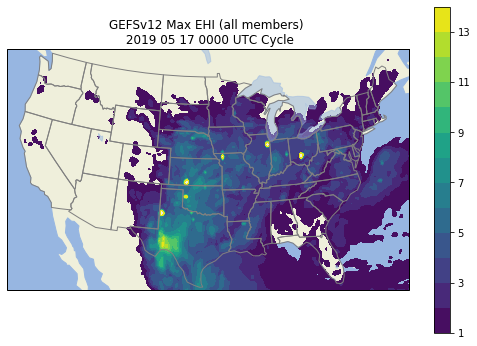

In [9]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection = cartopy.crs.LambertConformal())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, edgecolor='grey')
plt.contourf(ehi_ds.lon_0.values,ehi_ds.lat_0.values,ehi_ds.max(dim='ensemble').max(dim='forecast_time0').values,
             transform = cartopy.crs.PlateCarree(), levels=np.arange(1,15,1))
plt.title('GEFSv12 Max EHI (all members) \n 2019 05 17 0000 UTC Cycle')
ax.set_extent([-120, -73, 23, 50])
plt.colorbar()
plt.show()